### 预处理

In [17]:
import pandas as pd
import os
from itertools import chain

isnull = lambda x : True if len(str(x).strip())==0 \
                or (str(x).lower() in ['nan', 'none', r'\N', r'\n'])   \
                else False
                
notnull = lambda x : False if isnull(x) else True
extend_list = lambda x : list(chain(*x))

def cut_sent(para):
    import re
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略号
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略号
    para = re.sub('([!。！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('([!。！？\?][”’])([^!，。！？\?])', r'\1\n\2', para)
    # 如果双引号前有终止符，那么双引号才是句子的终点，把分句符\n放到双引号后，注意前面的几句都小心保留了双引号
    para = para.rstrip()  # 段尾如果有多余的\n就去掉它
    # 很多规则中会考虑分号;，但是这里我把它忽略不计，破折号、英文双引号等同样忽略，需要的再做些简单调整即可。
    return para.split("\n")


def read_txt(path, line_split=True):
    try:
        with open(path, encoding = 'utf-8') as f:
            l = [x.strip() for x in f.readlines() if len(x.strip())!=0]
    except:
        with open(path, encoding='gbk') as f:
            l = [x.strip() for x in f.readlines() if len(x.strip())!=0]
    
    if line_split:
        return l
    else:
        return [' '.join(l)]


def have_chinese(ss):
    for s in ss:
        if s >= u'\u4e00' and s<=u'\u9fa5':
                return True
    return False 

def all_chinese(ss):
    for s in ss:
        if not((s >= u'\u4e00' and s<=u'\u9fa5')):
                return False
    return True

def word_filter(s):
    if len(s)<2:
        return False
    
    if not all_chinese(s.replace(' ', '')):
        return False
    if s.split(' ')[0] in stopwords:
        return False
    if s.split(' ')[-1] in stopwords:
        return False
    return True


def remove_aite(text):
    # 删除空格
    import re
    text = re.sub(r"@[^\s]*\s", "", text)
    text = re.sub(r"@[^\s]*$", "", text)
    text = re.sub(r"#[^#]*#", "", text)
    text = re.sub(r"【[^】【]*】", "", text)

    return text

OUTPUT_DIR = r"结果"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

stopwords = read_txt(r"stopwords.txt") + []

setword_mine = read_txt(r"setwords.txt")

import jieba
for w in setword_mine:
    jieba.add_word(w)
tokenizer = lambda x: [xx for xx in jieba.cut(str(x).lower()) if len(xx.strip())>0 and word_filter(xx.strip()) and (xx.strip() not in stopwords)]


In [18]:
import os
import pandas as pd

df = pd.read_excel(os.path.join("data", "消极（总）.xlsx"))


In [19]:
def remove_whitespace(text):
    # 删除空格
    import re
    text = re.sub(r"\s+", "", text)

    return text.strip()

def DBC2SBC(ustring):
    # 全角转半角
    rstring = ""
    for uchar in ustring:
        inside_code = ord(uchar)
        if inside_code == 0x3000:
            inside_code = 0x0020
        else:
            inside_code -= 0xfee0
        if not (0x0020 <= inside_code and inside_code <= 0x7e):
            rstring += uchar
            continue
        rstring += chr(inside_code)
    return rstring

def zh2ch(s):
    # 繁体转简体
    import opencc
    converter = opencc.OpenCC('t2s')
    return converter.convert(s)

def filter_text(s):
    
    if '鹅鸭杀' in s:
        return False

    if '超话' in s:
        return False

    if '分享' in s:
        return False
    
    if '微博' in s:
        return False
    
    if '新闻' in s:
        return False
    
    if '网页链接' in s:
        return False
    
    if '@' in s:
        return False

    if s.count('#')>3:
        return False

    if len(s.strip())<8:
        return False


    if len(s.strip())>40:
        return False

    if isnull(s):
        return False
    
    if not have_chinese(s.strip()):
        return False
    return True


# 大写转小写
df['text'] = df.apply(lambda x : str(x['text']).strip().lower(), axis=1)
df['text']  = df.apply(lambda x : zh2ch(DBC2SBC(x['text'])), axis=1)
df['text'] = df.apply(lambda x : remove_aite(remove_whitespace(x['text'])), axis=1)

df = df.drop_duplicates(subset=['text'])

df['flag'] = df.apply(lambda x :filter_text(x['text']), axis=1)
df = df[df['flag']]
df = df.drop('flag', axis=1)
print(df.head())

          name                                             content  \
3      燕归巢小wing                     网红只要卖东西基本就是靠骗的唉珠妈也被扒了幻灭我在:2思南路   
8   华晨宇的无敌可爱菲菲君  搜噶骗转发杠杠地//@温婕-:网红//@逗逗是小炸鸡:卧槽原博.....//@晨宇的粉红小枕...   
9        面膜小王子-                             谁说网红不高高在上的，人气高点就是明星似的。   
10    wasabingo       炸出野生逼里勃一只//@蕉蕉得我一个:当网红是吧驳上位是吧我们还就不痒不痛了来咬我啊丑狗   
11    爱吃花噌鱼的疯圈儿  我说最近怎么没有@郭辰萱的动态了。原来。真是想不到啊//@我在静待花开://@花爷家的kk:...   

        release time                            text  positive  negative  \
3   2014-01-10 01:30  网红只要卖东西基本就是靠骗的唉珠妈也被扒了幻灭我在:2思南路  0.000049  0.999951   
8   2014-01-16 16:04                      搜噶骗转发杠杠地//  0.009406  0.990594   
9   2014-01-24 22:47          谁说网红不高高在上的,人气高点就是明星似的。  0.097933  0.902067   
10  2014-01-24 19:03                     炸出野生逼里勃一只//  0.127396  0.872604   
11  2014-01-24 12:04                        我说最近怎么没有  0.054052  0.945948   

    sentiment sentimental polarity  sentimental score  
3           0                  neg          -0.999951  
8         

In [20]:
name = '1'
d1 = df.__deepcopy__()
list_text = list(df['text'])
print(len(df))

3249


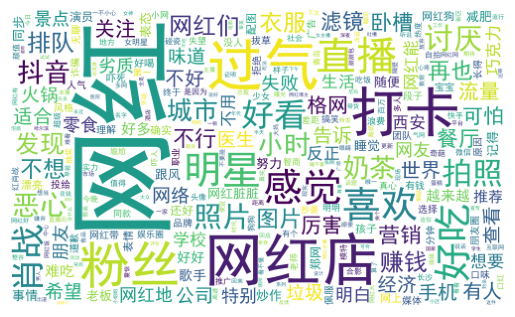

In [21]:
# 词频
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(max_features=20000, analyzer='word', tokenizer=tokenizer, stop_words=stopwords, ngram_range=(1, 1))
fre_matrix = cv.fit_transform([ ''.join(list_text)]).toarray()
fre_matrix = np.sum(fre_matrix, axis=0).tolist()
word_fre = [[x, y] for x,y in zip(cv.get_feature_names_out(), fre_matrix)]
dict_word_fre = {x:y for x,y in word_fre}
df_wordfre = pd.DataFrame(word_fre, columns=['单词', '频次'])
df_wordfre = df_wordfre.sort_values(by='频次', ascending=False)


df_wordfre['flag'] = df_wordfre.apply(lambda x :word_filter(x['单词']), axis=1)
df_wordfre = df_wordfre[df_wordfre['flag'] ]
df_wordfre = pd.DataFrame(df_wordfre, columns=['单词', '频次'])

df_wordfre.to_excel(os.path.join(OUTPUT_DIR, name + '_词频统计.xlsx'), index=False)

import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

dict_word_fre = {x:y for x, y in zip(list(df_wordfre['单词']), list(df_wordfre['频次']))}
my_cloud = WordCloud(width=500, height=300, max_words=300, 
    background_color='white', font_path='simhei.ttf', random_state=50
    ).generate_from_frequencies(dict_word_fre)
my_cloud.to_file(os.path.join(OUTPUT_DIR, name + '_词频词云图.png'))

plt.imshow(my_cloud)
plt.axis("off")
plt.show()


In [22]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from transformers.pipelines import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


#n_topics = 'auto'
n_topics = 10
# 文本编码算法
embedding_model = SentenceTransformer(r"paraphrase-multilingual-MiniLM-L12-v2")

# 2. 降维算法（三选一, 没讲究）
dim_model = UMAP(n_components=5, random_state=10)


# 3. 聚类算法(如果确定主题个数就选KMeans， 不确定就选HDBSCAN)
# n_clusters为kmeans聚类个数
cluster_model = KMeans(n_clusters=n_topics)

# min_cluster_size（最小聚类大小）可以让调节主题数量，该数值越大，则发掘出的主题数量就越少
# cluster_model = HDBSCAN(min_cluster_size=2, prediction_data=True)


# 4. 提取关键词
# ngram_range: 如果想提取关键短语的话，可以通过这个参数设置，参考3.4
# reduce_frequent_words：是否过滤掉特别常见的词
vectorizer_model = CountVectorizer(analyzer='word', 
        tokenizer=tokenizer, stop_words=stopwords, ngram_range=(1, 1))
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


# 5. 调整关键词的算法（二选一， 一般keybert]）
# representation_model = KeyBERTInspired()

# MaximalMarginalRelevance算法, 使提取的关键词之间的含义尽可能不同, diversity越大，关键词越不同。
representation_model = MaximalMarginalRelevance(diversity=0.3)

topic_model = BERTopic(
                    embedding_model=embedding_model,
                    umap_model=dim_model,
                    hdbscan_model=cluster_model,
                    vectorizer_model=vectorizer_model,
                    ctfidf_model=ctfidf_model,
                    representation_model=representation_model,
                    nr_topics = n_topics
                    )
topics, probs = topic_model.fit_transform(list_text)

print(topic_model.get_topic_info())

   Topic  Count            Name  \
0      0    618   0_医生_面膜_差距_发现   
1      1    303  1_网红店_经济_品牌_营销   
2      2    341   2_畜牲_不信_劣质_团队   
3      3    324   3_好吃_奶茶_零食_口味   
4      4    223   4_武汉_城市_泰国_昆明   
5      5    378  5_粉丝_讨厌_媒体_红肖战   
6      6    276  6_直播_歌手_演员_女明星   
7      7    317   7_手机_自拍_发型_化妆   
8      8     44  8_网红狗_狗狗_小狗_狗子   
9      9    425   9_道歉_过气_回应_总裁   

                                   Representation  \
0        [医生, 面膜, 差距, 发现, 太丑, 医院, 尿酸, 春天, 疫情, 卵子]   
1      [网红店, 经济, 品牌, 营销, 市场, 挣钱, 卖东西, 值得, 行业, 质量]   
2      [畜牲, 不信, 劣质, 团队, 门卫, 掩饰, 明目张胆, 大战, 说话, 小偷]   
3      [好吃, 奶茶, 零食, 口味, 酸奶, 网红饭, 餐饮, 食品, 吃法, 睡不着]   
4      [武汉, 城市, 泰国, 昆明, 街区, 东京, 王思聪, 广场, 花园, 千岛湖]   
5    [粉丝, 讨厌, 媒体, 红肖战, 流量, 娱乐圈, 网上, 网红主播, 喜欢, 全民]   
6    [直播, 歌手, 演员, 女明星, 少女, 赵丽颖, 唱歌, 粉丝, 妓女, 倩女幽魂]   
7       [手机, 自拍, 发型, 化妆, 打扮, 不帅, 女生, 镜子, 朋友圈, 美颜]   
8  [网红狗, 狗狗, 小狗, 狗子, 警犬, 悲惨生活, 房东, 扬言, 扫地出门, 流浪狗]   
9        [道歉, 过气, 回应, 总裁, 恶心, 默默, 嫌弃, 尴尬, 承认, 可怜]   

                              

In [23]:
# 输出文本-主题， 和 主题-关键词 结果
d1['topic_bertopic'] = topics
d1.to_excel(os.path.join(OUTPUT_DIR, name+'_主题分析_bertopic.xlsx'), index=False)


df_res = topic_model.get_topic_info()
df_res['关键词_c-tfidf得分'] = df_res.apply(lambda x: topic_model.get_topic(x['Topic']),axis=1)
df_res.to_excel(os.path.join(OUTPUT_DIR, name+'_主题分析_bertopic主题信息.xlsx'), index=False)


dd = pd.DataFrame(df_res, columns=['Topic', '关键词_c-tfidf得分'])
dd.columns=['topic', 'terms']
dd = dd.explode('terms')
dd['word'] = dd.apply(lambda x:x['terms'][0], axis=1)
dd['score'] = dd.apply(lambda x:x['terms'][1], axis=1)
dd['topic'] = dd.apply(lambda x: 'topic_'+str(x['topic']), axis=1)
dd.drop("terms", axis=1, inplace=True)
dd.to_excel(os.path.join(OUTPUT_DIR, name+'_主题关键词_bertopic.xlsx'), index=False)
print(dd.head(5))


     topic word     score
0  topic_0   医生  0.312619
0  topic_0   面膜  0.257463
0  topic_0   差距  0.252795
0  topic_0   发现  0.246258
0  topic_0   太丑  0.230282


In [24]:
fig = topic_model.visualize_barchart(top_n_topics=len(set(topics)), n_words=20, 
                               width=500, height=500)

fig.write_html(os.path.join(OUTPUT_DIR, name+"file1.html"))

# 整体文本-主题 分布
fig = topic_model.visualize_documents(list_text,width=1000, height=1000)
fig.write_html(os.path.join(OUTPUT_DIR, name+"file2.html"))

fig = topic_model.visualize_heatmap(width=1300, height=1000)
fig.write_html(os.path.join(OUTPUT_DIR, name+"file3.html"))

fig = topic_model.visualize_hierarchy(width=1000, height=1000)
fig.write_html(os.path.join(OUTPUT_DIR, name+"file4.html"))